Importing necessary libraries:

In [11]:
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [12]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

#### Using pretrained model VGG-19 as a feature extractor: 

In [13]:
vgg = models.vgg19(pretrained = True).features
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Geekquad/.torch\models\vgg19-dcbb9e9d.pth
100.0%


In [14]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Loading Content and Style Images:

In [16]:
def load_image(img_path, max_size=400, shape=None):
   
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [20]:
content = load_image('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg')
style = load_image('deep-learning-v2-pytorch/style-transfer/images/hockney.jpg', shape=content.shape[-2:])

In [29]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image =image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.25)) + np.array((.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

Displaying the Content and Style Image side by side:

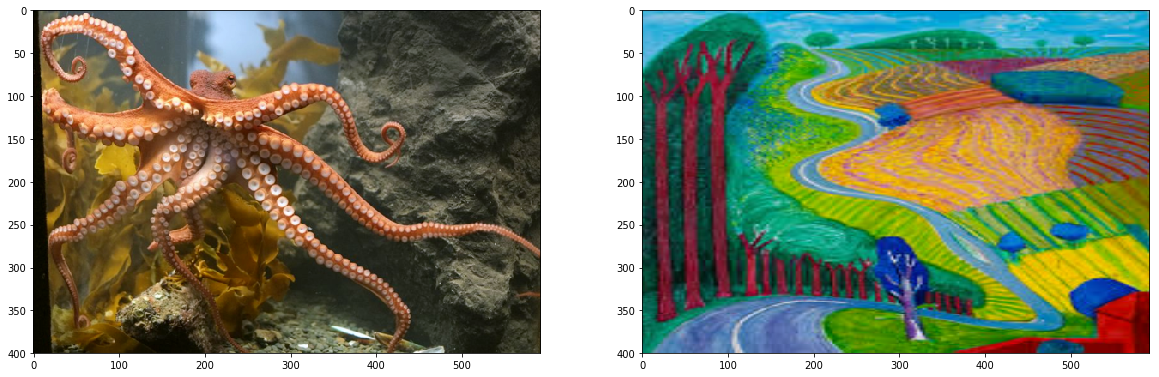

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))